# 7. Seq2seq와 Attention
### 학습 목표
1. 언어 모델이 발전해 온 과정을 개략적으로 파악한다.
2. 기존 RNN 기법이 번역에서 보인 한계를 파악하고, 이를 개선한 Seq2seq를 이해한다.
3. Seq2seq를 발전시킨 Attention에 대해 알아본다.

## 7-2. 우리가 만드는 언어 모델
### 언어 모델(Language Model)
주어진 단어들을 보고 다음 단어를 맞추는 모델. __단어의 시퀀스를 보고 다음 단어에 확률을 할당하는 모델__. n-1개의 단어 시퀀스 $w_1, ..., w_{n-1}$이 주어졌을 때, n번째 단어 $w_n$으로 무엇이 올지 예측하는 확률 모델.

(엄밀히 말하면 주어진 단어들/문장에 확률을 할당하는 모델이 언어모델이고, 주어진 문맥에서 모르는 단어를 예측하는 것이 언어모델링이다. 위의 정의에 따르면 주어진 단어 시퀀스에 확률을 할당하고 언어모델링(다음 단어의 확률 예측)을 할 수 있는 모델이 언어모델인가?)

- 파라미터 $\theta$로 모델링하는 언어 모델: $P(w_n|w_1, ..., w_{n-1};\theta)$

- 참고: 시퀀스 형태의 Next Token Prediction 언어모델 외에 주변 단어를 보고 중심 단어를 예측하는 형태로 언어모델을 구성하는 것도 있다.

### 통계적 언어 모델 (Statistical Languagel Model)
딥러닝이 등장하기 이전에 사용되던 언어 모델. 예: 2000년대 초반의 구글과 네이버의 번역기

- [언어모델(Language Model)](https://ratsgo.github.io/from%20frequency%20to%20semantics/2017/09/16/LM/)
>- 언어모델: 단어 시퀀스에 대한 확률 분포. 언어모델은 context-dependent이므로 학습 데이터에 민감하다(학습 데이터에 따라 확률 분포가 달라진다).     
>- 언어모델의 이점: 단어 시퀀스의 출현 확률분포로 단어의 시퀀스를 뽑을 수 있다. 즉 해당 언어모델로 텍스트를 생성할 수 있다. (생성모델(generative model)이라고도 불림) 
>- 유니그램 언어모델: 가장 단순한 통계적 언어모델의 예         
>각 단어가 서로 독립이라고 가정할 대, n개 단어가 동시에 나올 확률은 $P(w_1, ..., w_n)= \prod_{i=1}^n P(w_i)$ 이다. 유니그램 모델은 각 단어의 등장 순서가 바뀌어도 개별 단어 확률의 곱은 변하지 않기 때문에 단어 셋을 고려한다. 
> 학습말뭉치에 등장한 각 단어 빈도를 세어서 전체 단어수로 나누어준 것을 각 단어 당 확률로 한다. 
>유니그램 모델에서는 말뭉치 등장 빈도가 높은 단어가 많이 포함된 문서일수록 해당 문서의 출현확률이 높아진다. 즉 등장빈도가 높은 단어가 해당 문서의 주제일 수 있다. 다른 말뭉치로 학습한 모델이라면 같은 문서라도 확률값이 크게 달라진다.        
>언어 모델 $\theta$를 학습한다는 것은 각 단어 w의 등장확률을 추정하는 것이다. 한정된 데이터를 바탕으로 그럴듯한 언어 모델 $\theta$를 추정해야 한다.   
>- 언어모델의 한계     
>1) 학습말뭉치에 존재하지 않는 단어의 확률은 0이 된다. 학습말뭉치에 의존적이라 충분한 데이터가 없다면 범용적인 모델을 구축하기 어렵다.   
>2) 조사, 어미 등의 기능적 단어의 빈도가 높아 원하는 결과를 내기 쉽지 않다. 

- 통계적 언어모델의 단점: 새로운 단어나 문장에 대해 모델링을 할 수 없다. 

(주어진 문맥에서 모르는 단어를 예측하는 것이 언어모델링)

### 신경망 언어 모델 (Neural Network Language Model, NNLM)
NNLM의 시초는 Feed-Forward 신경망 언어모델(단어간 유사도를 반영한 벡터를 만드는 Embedding 레이어의 아이디어인 모델)이다. 
- [피드 포워드 신경망 언어 모델(NNLM)](https://wikidocs.net/45609)    
>- 희소문제(sparsity problem): 충분한 데이터를 관측하지 못하면 언어를 정확히 모델링하지 못하는 문제. 한 번도 관측하지 못한 데이터에 대해선 0에 확률을 부여한다.     
>희소문제는 언어모델이 단어의 유사도를 학습할 수 있다면 해결할 수 있다. 이런 아이디어를 가지고 탄생한 언어모델이 신경만 언어모델 NNLM이다. 

NNLM은 각 단어를 Embedding 벡터로 표현한 후, 이전의 몇 개의 단어를 사용해 다음 단어를 예측할 수 있다. NNLM은 희소 문제를 해결했을 뿐 아니라 __단어 간의 유사도__ 를 표현하여 문장의 유창성을 높게 했다. 그러나 예측에 사용되는 단어가 __정해져__ 있다는 단점이 있다. 즉 입력 단어가 정해져 있으면 긴 문장이 들어왔을 경우, 모든 문맥을 파악하지 못한다. 따라서 __순환 신경망__(Recurrent Neural Network, RNN)을 활용한 언어 모델이 탄생되었다.  

## 7-3. Sequence to Sequence 문제
RNN은 고정된 크기의 Weight가 선언되지만 __입력을 순차적으로 '적립'__ 하여 유동적인 크기의 입력을 처리할 수 있다. 

### RNN의 문제점
1) 기울기 소실(Vanishing Gradient) 문제     
하나의 Weight에 입력을 적립하므로 입력이 길어질수록 이전 입력에 대한 정보가 소실된다. 

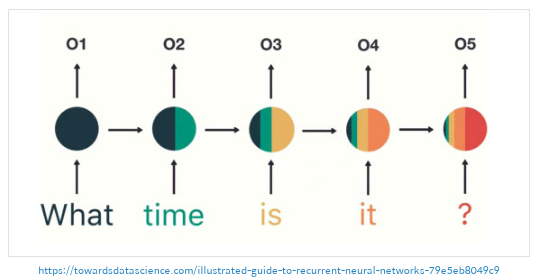

-> 해결: [LSMT](https://dgkim5360.tistory.com/entry/understanding-long-short-term-memory-lstm-kr)

2) 문장 번역이 어렵다.
RNN 구조는 문장 생성에는 적합하지만 번역에 사용하기에는 어렵다. 각 언어별로 어순이 다르고, 입력의 길이와 번역문의 길이가 다를 수 있다. 

-> 해결: 문장 전체를 보고 번역하는 Sequence to Sequence(Seq2Seq) 구조

- 논문: [Sequence to Sequence Learning with Neural Networks](https://papers.nips.cc/paper/2014/file/a14ac55a4f27472c5d894ec1c3c743d2-Paper.pdf)

![](https://images.velog.io/images/guide333/post/9ca8e445-415e-4441-813b-26d04039ccce/Screenshot%20from%202021-04-15%2013-03-47.png)

- 논문 정리: [Seq2seq (2): Sequence to Sequence Learning with Neural Networks](https://reniew.github.io/35/)

- [시퀀스-투-시퀀스](https://wikidocs.net/24996): 작동 방식에 대한 자세한 설명

![](https://images.velog.io/images/guide333/post/f1e8fe2a-2391-4d3e-8092-e2a17ef3eaea/Screenshot%20from%202021-04-15%2013-20-27.png)

시작 토큰이 없는 경우, Decoder의 첫 입력으로 전달할 단어가 없어져 번역을 진행할 수 없다. 랜덤한 단어를 입력으로 넣는 경우, 번역의 성능에 문제가 생긴다.
끝 토큰이 없는 경우, 문장의 끝을 알릴 수 없어 단어를 무한정 생성하게 된다. 

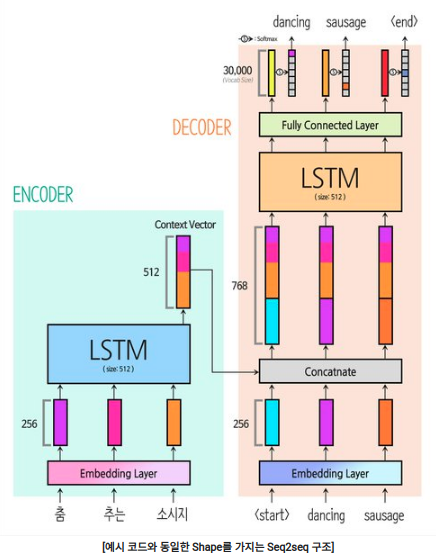

![](https://images.velog.io/images/guide333/post/493caf0c-4c17-4536-abe6-07799fa89d17/Screenshot%20from%202021-04-15%2014-32-54.png)

($x_i$: Input Sequence, $y_i$: Output Sequence, v: 컨텍스트 벡터)

Encoder가 생성한 컨텍스트 벡터 v 를 Embedding 레이어를 거친 y 값에 Concatnate하여 Seq2seq를 완성했다. 

## 7-5. Attention! (1) Bahdanau Attention
### Bahdanau Attention
Seq2Seq의 컨텍스트 벡터가 고정된 길이로 정보를 압축되는 것은 정보의 손실을 야기한다. 즉 압력 문장이 길어질수록 모델의 성능이 저하된다. 따라서 Bahdanau는 매 스텝의 Hidden State를 활용해 컨텍스트 벡터를 구축하는 Attention 메커니즘을 제안하였다.

- 논문: [ NEURAL MACHINE TRANSLATION BY JOINTLY LEARNING TO ALIGN AND TRANSLATE](https://arxiv.org/pdf/1409.0473.pdf): 꼭 읽기
- 정리 글: [Attention mechanism in NLP. From seq2seq + attention to BERT ](https://lovit.github.io/machine%20learning/2019/03/17/attention_in_nlp/)

#### 정리 글 정리

- attention의 장점    
seq2seq의 컨텍스트 벡터 개선-> 모델 성능 향상, attention weight matrix를 이용한 모델의 작동 방식에 대한 시각화를 통해 모델의 안정성을 점검하고 모델이 의도와 다르게 작동할 때 원인을 찾는데 사용된다.     


- $\alpha_{ij}$: attention weight, decoder RNN이 $y_i$를 선택할 때 encoder RNN의 $h_j$를 얼마나 이용할 것인지를 결정, neural network에 의해 학습됨
- $c_i$: $y_i$의 컨텍스트 벡터. $\sum_j \alpha_{ij} \cdot h_j$ ($\sum_j \alpha_{ij}=1$, $\alpha_{ij} \ge 0)$ 


![](https://images.velog.io/images/guide333/post/f869ff90-b9e3-4fa5-8e61-4ca9040b648b/Screenshot%20from%202021-04-15%2014-49-03.png)

Weight는 decoder의 이전 hidden state $s_{i-1}$와 encoder의 hidden state $h_j$가 입력되는 feed-forward neural network이다. 출력값 $e_{ij}$는 하나의 숫자이며, 이를 softmax로 변환해 확률로 표현한다. 이 확률을 encoder hidden vectors의 weighted average vector로
만들어 context vector $c_i$로 이용한다. 

![](https://images.velog.io/images/guide333/post/c3a29154-f6e2-47c7-9a8d-ac124bb67f8f/Screenshot%20from%202021-04-15%2016-09-49.png)

Attention을 계산하는 feed-forward network는 input vector $[s_{i-1};h_j]$에 대한 1 layer feed forward neural network이다. 

$$e_{ij} = f(W^1s_{i-1} + W^2h_j)$$

attention이 이용되면서 '이것'이라는 단어를 선택하기 위해 'this is'라는 부분에 주목하게 된다.  
![](https://images.velog.io/images/guide333/post/6d4586cc-3b3e-49e7-ac35-a2ae3d9faa88/Screenshot%20from%202021-04-15%2016-02-10.png)

그 결과로 attention weigth matrix를 얻을 수 있다. 아래의 그림은 단어끼라의 attention weight를 표현한 그림이다. 흰 색일수록 높은 attention weigt이다. 관사끼리는 서로 연결되어 있고, 의미가 비슷한 단어끼리 높은 attention weight를 가진다. 하나의 단어가 두 개 이상의 단어의 정보를 조합해 이용하기도 한다.  

![](https://images.velog.io/images/guide333/post/8af84b94-fa58-4d9f-90c1-26fb020caf19/Screenshot%20from%202021-04-15%2016-20-32.png)

그러나 한 단어 $y_i$를 만들기 위해 이용되는 $h_j$는 많지 않다. 즉 decoder는 context를 선택적으로 이용한다는 뜻이다. 

그럼에도 Attention mechanism은 같은 크기의 공간을 이용하는 RNN이 더 좋은 성능을 가지도록 했고 RNN이 seqeuece encoding을, attetion이 context vector를 만드는 식으로 일을 나눠 네트워크에 부하를 줄여주었다.

- Sequence Labeling과 Sequence to Sequence의 예시와 차이점    
  - Sequence Labeling: $x_i$와 $y_i$의 관계를 구하는 문제, 두 단어열의 길이가 같다. 
  - Sequence to Sequence는 $x_{1:n}$과 동일한 의미를 가지는 $y_{1:m}$을 만드는 문제, 입력과 출력 시퀀스의 길이가 다를 수 있다.
  
### seq2seq과 attn-seq2seq, 뭐가 다른가?

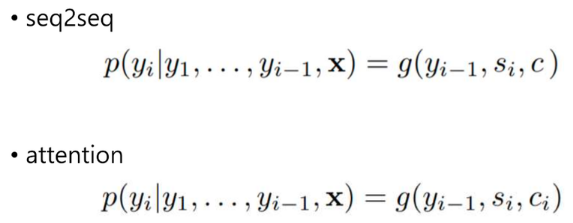

위의 두 식의 차이는 context vector c에 첨자 i가 붙어있다는 것이다.

![](https://images.velog.io/images/guide333/post/9003776d-c335-4154-9a84-b93611ed4db6/Screenshot%20from%202021-04-15%2016-27-11.png)

위 그림은 Bahdanau 논문 원문의 [3.LEARNING TO ALIGN AND TRANSLATE]의 내용을 바탕으로 재구성한 것이다. 왼쪽 부분은 $X_j$를 입력, $y_i$를 출력으로 하는 인코더-디코더 부분이다. 주의할 점은 __i는 디코더의 인덱스, j는 인코더의 인덱스__ 라는 점이다. 

>$c_i$의 의미: 인코더가 입력 X를 해석한 context $c_i$는 디코더의  포지션 i에 따라 다르게 표현된다. 
 
- 번역: '나는 밥을 먹었다'-> 'I ate lunch'        
영어 문장의 첫 번째(i=0) 단어 'I'를 만들어야 할 때 인코더가 한글 문장을 해석한 컨텍스트 벡터에서는 '나는'이 강조되어야 하고, 영어 문장의 세 번째(i=2) 단어 'lunch'를 만들어야 할 때 인코더의 컨텍스트 벡터에서는 '밥을'이 강조되어야 한다. 

즉 __디코더가 현재 시점 i에서 보기에 인코더의 어느 부분 j가 중요한가?__ 를 알려주는 가중치가 attention이다. $\alpha_{ij}$가 인코더의 j번째 hidden state $h_j$가 얼마나 강조되어야 하는지 결정하는 가중치이다. 이 가중치는 encoder의 hidden state $s_{i-1}$와 $h_j$의 유사도가 높을수록 높아진다. 

- [Attn: Illustrated Attention](https://eda-ai-lab.tistory.com/157): attention 레이어의 구현과 시각화

#### 정리
attention은 모든 인코더의 hidden state 값을 디코더에 제공한다. 이를 통해 모델이 입력된 문장의 유용한 부분에 집중하게 되므로 모델 간의 얼라인먼트(alignment: 원본 텍스트의 단어를 번역의 해당 단어와 일치시키는 것)을 학습할 수 있다. 따라서 긴 입력 문장에 효과적으로 대처할 수 있다. 

- attention 레이어의 구현
0. hidden state의 준비    
첫 번째 디코더 hidden state와 모든 인코더 hidden state를 준비한다. 
1. 모든 인코더 hidden state의 점수 얻기   
hidden state의 점수는 아래의 평가 점수(특정 벡터 공간으로 매핑된 두 hidden state의 합)에 의해 얻어진다. 

![](https://images.velog.io/images/guide333/post/944bda27-1363-4f46-9ad3-6f2c552179a0/Screenshot%20from%202021-04-15%2016-27-21.png)

2. 1에서 얻은 모든 점수를 softmax 레이어를 통과시킨다.     
이 소프트맥스 점수는 attention 분포이다.
3. 각 인코더 hidden state에 softmaxed 점수를 곱한다.     
그 결과가 얼라이먼트 벡터 또는 annotation 벡터이다. (annotation : Encoder의 hidden state를 의미) 
4. 얼라이먼트 벡터를 합친다.    
얼라이먼트 벡터는 합쳐져 context 벡터가 생성된다.         
5. context 벡터를 디코더에 전달된다.     
Decoder의 이전 Hidden State와 Concatnate하여 새로운 Hidden State로 정의된다.

![](https://images.velog.io/images/guide333/post/1c30706f-5a2e-4568-9ae6-320ce9310081/Screenshot%20from%202021-04-15%2017-04-36.png)

바다나우 어텐션의 컨텍스트 벡터는 핵심 단어(비중이 큰 단어)에 가장 근접하게 다가서되, 주변 단어에도 각각의 비중만큼 영향을 받아 문장을 적합한 위치에 매핑되게 한다.



## 7-6. Attention! (2) Luong Attention
### Luong Attention
Luong의 Attention은 Bahdanau의 방식을 약간 발전시킨 형태이다. 

- 논문: [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/pdf/1508.04025.pdf)

- [[Attention] Luong Attention 개념 정리](https://hcnoh.github.io/2019-01-01-luong-attention)

#### 정리
- Bahdanau Attention과의 차이점   
  - 디코더의 Hidden State Vector를 구하는 방식이 간소화 -> Attention Mechanism의 Computation Path 간소화
  - Local Attention과 그것을 위한 Alignment Model 제시
  - 다양한 Score Function들을 제시
  
즉 Hidden State Vector를 구하는 방식이 달라졌고 Local Attention을 사용했다는 점이 차이점이다. 

- hidden state

[Bahdanau Attention(Global attention)의 computation path]
![](https://images.velog.io/images/guide333/post/2d97926b-ac9a-4f57-92f8-88a423ed4008/Screenshot%20from%202021-04-15%2017-14-27.png)

현재 시점의 디코더의 hidden state vector $s_t$ = 현재 시점의 context vector$c_t$ + 이전 시점의 hidden state vector$s_{t-1}$ + 현재 시점의 입력
$y_t$  (여기서 + 는 더한다는 뜻이 아님)

$c_t = \sum_{j=1}^{T_x} a_{tj}h_j = Ha_t$      
$a_t = Softmax((score(s_{t-1}, h_j))^{T_x}_{j=1}) \in \mathbb R^{T_x}$      
$Score(s_{t-1}, h_j) = v^T tanh(W_a s_{t-1} + U_ah_j)$

[Luong Attention: Local attention)의 computation path]
![](https://images.velog.io/images/guide333/post/70971334-90a6-41f0-a3b8-52f8cc6d8c87/Screenshot%20from%202021-04-15%2017-14-35.png)

$c_t$를 구할 때 $s_t$를 사용한다. hidden state vector $s_t$는 RNN의 hidden state 역할만 하고, 출력 $\hat y_t$를 구할 때는 새로운 $\bar s_t$를 거친다. 

이 경우 computation path가 간소화된다. 바다나우 어텐션에서는 디코더의 Hidden State의 역할을 하는 $s_t$를 구할 때 context vector $c_t$가 사용되므로 RNN의 재귀 연산이 수행될 때 $c_t$가 구해질 때까지 기다려야 하지만 루옹 어텐션의 경우 출력 $\hat y_t$을 구하는 부분과 RNN의 재귀 연산이 수행되는 부분이 분리되었기 때문에 computation path가 간소화된다

$c_t = \sum_{j=1}^{T_x} a_{tj}h_j = Ha_t$      
$a_t = Softmax((score(s_{t}, h_j))^{T_x}_{j=1}) \in \mathbb R^{T_x}$      
$\hat y_t = Softmax(W_y \bar s_t + b_y)$
$s_{t} = tanh(W_{ss} s_{t} + W_{cs}c_t + b_s)$'


- Local Attention과 이를 위한 Alignment Model    
인코더의 모든 hidden state의 벡터를 보는 바다나우 어텐션과 달리 루옹 어텐션은 특정 하이퍼파라미터 D에 대해 (2D+1)개의 부분집합 벡터만 본다.

![](https://images.velog.io/images/guide333/post/c1dd57c6-8714-4b2f-a35e-7f90d5dd3946/Screenshot%20from%202021-04-15%2017-36-56.png)

여기서 $p_t$는 Aligned Position이라고 정의하며 $p_t$를 구하는 방식에 따라 Local Attention의 방법이 달라진다. 
  
  - Monotonic Alignment(local-m): $p_t = t$
  - Predictive Alignment(local-p): $p_t = T_x \cdot Sigmoid(v_p^T tanh(W_p s_t)$
  
이렇게 구해진 $a_t$와 범위 $[p_t-D, p_t + D]$에 대해서 weighted sum을 통해 context vector $c_t$를 구한다. 

$c_t = H[:, p_t-D : p_t + D + 1]$

- 다양한 Score Function 제시 및 비교

![](https://images.velog.io/images/guide333/post/21bf5959-e5ad-44ae-a0a1-52f77fde07f0/Screenshot%20from%202021-04-15%2017-42-19.png)

Location-Based Function은 Attention이 필요하다. 4개의 함수 중 가장 합리적인 성능을 보이는 함수는 General 함수이다.

- Input Feeding Approach    
현재 시점의 입력 $y_{t-1}$이 들어갈 때 이전 시점의 새로운 새로운 hidden state vector $\bar s_{t-1}$을 함께 concatenate하여 넣어주는 것이다. 이전의 Alignment 정보를 폭넓게 사용할 수 있고 네트워크를 수직/수평적으로 넓게 구현했다는 장점이 있다.

![](https://images.velog.io/images/guide333/post/d1593db8-f73d-4fdb-844c-c5df23880ac6/Screenshot%20from%202021-04-15%2017-43-45.png)

- 성능 비교          
Global Attention < Local-m < Local-p

Bahdanau의 Score 함수와는 다르게 Luong Attention은 하나의 Weight만을 사용한다. 어떤 벡터 공간에 매핑해주는 과정이 없기 때문에 Weight의 크기는 단어 Embedding 크기와 동일해야 연산이 가능하다. 

## 7-7. 미래의 기법
2016년 구글의 신경망 번역 시스템이 소개되었다. 8개 층을 쌓은 Encoder-Decoder 구조와 Residual Connection을 사용한 GNMT이다. 

- 논문: https://arxiv.org/abs/1609.08144

- [Google's Neural Machine Translation System.](https://norman3.github.io/papers/docs/google_neural_machine_translation.html)

#### 간단한 정리
NMT는 간단하지만 좋은 성능을 낸다. 그러나 몇 가지 단점이 있다. 

1. 느린 학습속도와 추론(inference) 속도: 데이터가 크고, 모델 파라미터가 너무 많다.  
2. rare words에 대한 부정확도: 사전에 없는 단어는 처리하지 못한다. (<unk\>로 처리)
3. 가끔 전체 입력 문장을 다 번역하지 않는다.

- GNMT 모델 구조
![](https://images.velog.io/images/guide333/post/6f919f52-0925-453e-938f-8d5dfe113e53/Screenshot%20from%202021-04-15%2023-54-54.png)

attention 기능이 들어간 seq2seq 모델. 그러나 8개의 LSTM encoder와 8개의 LSTM decoder를 사용한다. 

- Residual Connections
![](https://images.velog.io/images/guide333/post/1427c240-8a03-43a4-95da-6073467ca301/Screenshot%20from%202021-04-15%2023-58-24.png)

정확도를 올리고자 LSTM stack에 residual 노드를 넣는다. 번역 모델에 기본 LSTM 모델을 사용하면 4개 층까지는 잘 동작하나 6개부터는 문제가 생기고 8개는 제대로 동작하지 못하기 때문이다. Residual Connections을 사용하면 정확도가 올라가고 학습 속도가 빨라지며, Gradient Exploding / Vanishing 문제가 해결한다.

![](https://images.velog.io/images/guide333/post/e864b085-09a1-4494-a63b-e2b7d2ecb066/Screenshot%20from%202021-04-16%2000-02-40.png)

![](https://images.velog.io/images/guide333/post/b00e1eab-a561-4dd4-9336-0302261eac7d/Screenshot%20from%202021-04-16%2000-02-44.png)

(5)는 일반적인 LSTM 모델의 수식이고 (6)은 residual을 추가한 모델의 수식이다. ($x_t^i$: LSTM의 스텝 t일 때의 입력값, $m_t^i$와 $c_t^i$: 각 LSTM의 hidden 상태와 메모리 값) 실험결과 8 레이어의 LSTM이 가장 효과가 좋았다.

- Bi-directional Encoder for First Layer
![](https://images.velog.io/images/guide333/post/f6a1ee97-840e-4e7a-aefd-5d8cdba6b30f/Screenshot%20from%202021-04-16%2000-05-42.png)

컨텍스트를 충분히 살펴보기 위해서 bi-directional RNN을 사용해 입력 데이터를 양 방향에서 살펴본다. (첫 번째 레이어에만 적용)

- Model Parallelism     
모델이 복잡하므로 병렬 모델을 사용한다. 데이터 병렬화를 위해 Downpout SGD를 사용한다. 10개로 복사된 장비가 동일한 모델 파라미터를 공유하고 독립적으로 파라미터를 업데이트한다.장비당 8개의 GPU(층마다 다른 GPU 사용)를 사용하는 등 모델 병렬화를 했다. 

- Wordpiece Model     
sub-word unit 방식의 워드피스 모델 개발. 이런 방식으로도 얻을 수 없는 rare word는 copy model(처음 본 단어는 그냥 입력에서 출력으로 전달)을 사용한다. 
- copy model: 한 번도 본 적 없는 단어에 대해서 <UNK\> 토큰 처리를 하지 않고 단어를 그대로 복사하여 적당한 위치에 배치하는 모델

- Quantizable Model and Quantized Inference    
Quantized Inference를 통해 수치 정확도를 낮추어 빠른 연산을 수행하게 한다. 

- Decoder - beam search    
최종 출력 문자열 Y를 만들기 위해 beam search 를 사용한다. 빔서치를 최적화하기 위해 coverage penalty와 length normalization 기법을 소개한다. length normalization은 길이가 긴 문장의 확률값이 평가시 더 작아지기 때문에 보정하는 방법이다. 

GNMT의 레이어를 쌓는 구조나 Residual Connection이은 트랜스포머(Transformer)와 굉장히 유사하다. 

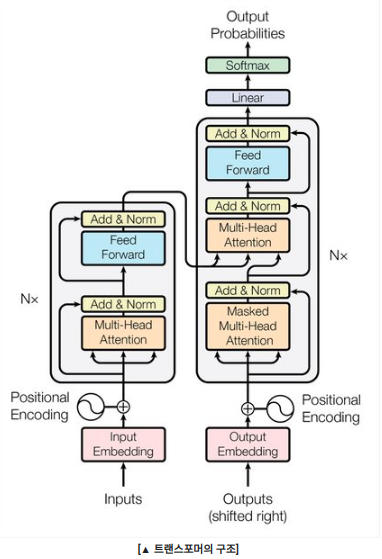

트랜스포머 모델은 Multi-Head Attention이라는 개념을 도입해 폭넓은 문맥을 파악하게 하고, 기존의 RNN 구조를 완전히 제거해 연산 속도 측면에서도 혁신적인 발전이 일어났다.